### ---
#### 最终结果数组
>`fra_b_over_a(4675,3)【已按照manga与nsa_v101匹配，结果为4000+星系，使用的是tmp_num_ij数组(nsa_vs_manga)】`   
>>0: 星系的fraDeV   
>>1: 星系的b/a椭圆度   
>>2: 星系筛选计数【=5即为挑选出的星系】  
    
>`num_sel_gal为最终筛选出的星系在原manga数组中的位置`
  

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.io import fits
import copy
from os.path import join
import math
import numpy as np
from matplotlib.colors import ListedColormap
from marvin.tools import Maps
import marvin.utils.plot.map as mapplot

new_ra_dec = np.loadtxt('/root/cosmos/data/nair_ra_dec_ba.txt')

# 读取nsa与manga的匹配数组
nsa_vs_manga = np.loadtxt("/root/.jupyter/cosmos/code_git/Metallicity-deviation/tmp_storage/nsa101_vs_manga.dat")

#read in the vac file
vac0 = fits.open('/root/cosmos/galaxies-mzr/data/manga_firefly-v2_4_3-STELLARPOP.fits') 
basic_manga = copy.copy(vac0[1].data)

# load the data of NASA-Sloan catalog v1 0 1
nsa101 = fits.open('/root/cosmos/data/nsa_v1_0_1.fits') 
basic_nsa = nsa101[1].data
nsa_ba = copy.copy(basic_nsa['PETRO_BA90'])
nsa_mass1 = copy.copy(basic_nsa['ELPETRO_MASS'])    #Stellar mass from K-correction fit (use with caution) for elliptical Petrosian fluxes
nsa_mass2 = copy.copy(basic_nsa['SERSIC_MASS'])    #Stellar mass from K-correction fit (use with caution) for Sersic fluxes

# http://skyserver.sdss.org/dr15/en/tools/search/IQS.aspx
# 衡量星系的年龄大小的量 fracDeV<0.7
fracDeV = np.loadtxt('lalala_manga_fradeV.txt')

# https://www.sdss.org/dr12/algorithms/classify/#photo_adaptive
# http://skyserver.sdss.org/dr15/en/help/docs/QS_UserGuide.aspx#SAS
# 筛选倾斜程度，椭圆的长轴短轴为a b
# 计算出每个星系的a b
# b/a>=0.3
#q_u = np.loadtxt('manga_Q_U_4675.txt')
#b_over_a = 2/((q_u[:,0]**2+q_u[:,1]**2)**0.5+1)-1


#########################################
# 去重
tmp_num_ij = nsa_vs_manga    # 临时存储一下，防止改动
#tmp_num_ij = tmp_num_ij[np.where((old_same_gal[:,0]==1) & (~np.isnan(nsa_ba)) & (tmp_num_ij[:,0]!=-999))]    # 筛选出未重复的星系编号 & 剔除无效数据nan
tmp_num_ij = tmp_num_ij[np.where(~np.isnan(nsa_ba))]    # 剔除nsa_b/a无效数据nan
tmp_num_ij = tmp_num_ij[np.where(tmp_num_ij[:,0]!=-999)]    # 将匹配到的有效位置提出，-999为初始值
a,last_num = np.unique(tmp_num_ij[:,0],return_index=True)    # 第一列nsa数据去重
tmp_num_ij = tmp_num_ij[last_num]
#tmp_num_ij = tmp_num_ij[np.where(~np.isnan(nsa_ba))]    # 
#a,num_last_same_gal = np.unique(last_same_gal[np.where(old_same_gal[:,0]==1),0],return_index=True)    # 第一列sdss数据去重
a,last_num = np.unique(tmp_num_ij[:,1],return_index=True)    # 第二列manga数据去重
tmp_num_ij = tmp_num_ij[last_num]
tmp_num_ij = tmp_num_ij.astype(np.int64)    #最后得到了最终版的nsa_vs_manga数组位置
######################################

b_over_a = nsa_ba[tmp_num_ij[:,0]]    # 根据数组位置提出nsa_b/a
#nsa_mass = nsa_mass1[tmp_num_ij[:,0]]

# 星系质量筛选
# stellar mass > 10^9 太阳质量
#glo_mass_id = basic_manga['PHOTOMETRIC_MASS'] > 10e8
manga_mass = basic_manga['PHOTOMETRIC_MASS']
manga_mass = manga_mass[tmp_num_ij[:,1]]    # 匹配数组维度
#glo_mass_id = glo_mass_id[tmp_num_ij[:,1]]    # 匹配数组维度
glo_mass_id = np.where(manga_mass>1e9)

# 星系star-forming区域筛选
# sfr spaxels >= 20
#plfu_sfr = np.loadtxt("/root/.jupyter/cosmos/code_git/Metallicity-deviation/plfu_sfr_spaxel.dat")
plfu_sfr = np.loadtxt("/root/.jupyter/cosmos/code_git/Metallicity-deviation/tmp_storage/plate_ifu_spaxel_v2.0.dat")
plfu_sfr = plfu_sfr[tmp_num_ij[:,1]]    # 匹配数组维度
sfr_id = np.where(plfu_sfr[:,2]>=20)

fra_b_over_a = np.zeros([4675,3])
fra_b_over_a[:,0] = fracDeV
fra_b_over_a = fra_b_over_a[tmp_num_ij[:,1]]
fra_b_over_a[:,1] = b_over_a
manga_id = tmp_num_ij[:,1]

# 开始筛选，在第三列进行判断计数
fra_b_over_a[np.where(fra_b_over_a[:,0]<0.7),2] += 1    # fracDeV筛选
sel_galaxy = np.where(fra_b_over_a[:,2]==1)
print("筛选fracDeV，得到late-type星系个数： ",np.shape(sel_galaxy)[1])

fra_b_over_a[np.where(fra_b_over_a[:,1]>=0.3),2] += 1    # b/a筛选
sel_galaxy = np.where(fra_b_over_a[:,2]==2)
print("筛选fracDeV+初步b/a，得到late-type+不是很倾斜的星系个数： ",np.shape(sel_galaxy)[1])

fra_b_over_a[np.where(glo_mass_id),2] += 1    # 星系总质量筛选
fra_b_over_a[sfr_id,2] += 1    # 星系形成区域筛选

sel_galaxy = np.where(fra_b_over_a[:,2]==4)    # 四次筛选结果

print("不考虑nair catalog时：","\n已从 manga 4675 个星系中找出 ",np.shape(sel_galaxy)[1]," 个星系","\n距论文中的 1222 个星系还差  ",np.shape(sel_galaxy)[1]-1222,"个")
print("\n替换nair_ba之前，b/a平均值 = ",np.mean(fra_b_over_a[:,1]))


#########################################################
# 第五次筛选：manga与nair匹配的星系中，nair_b/a < manga_b/a

# 读取manga vs nair 匹配数组
last_same_gal = np.loadtxt("/root/.jupyter/cosmos/code_git/Metallicity-deviation/tmp_storage/manga_vs_nair.dat")
# 去重
tmp_num_ij = last_same_gal    # 临时存储一下，防止改动
tmp_num_ij = tmp_num_ij[np.where(tmp_num_ij[:,0]!=-999)]    # 筛选出未重复的星系编号
#tmp_num_ij = tmp_num_ij[np.where(old_same_gal[:,0]==1)]    # 筛选出未重复的星系编号
#a,num_last_same_gal = np.unique(last_same_gal[np.where(old_same_gal[:,0]==1),0],return_index=True)    # 第一列sdss数据去重
a,last_num = np.unique(tmp_num_ij[:,1],return_index=True)    # 第二列nair数据去重，last_num为最后编号
tmp_num_ij = tmp_num_ij[last_num]
tmp_num_ij = tmp_num_ij.astype(np.int64)

# manga数组编号为tmp_num_ij[:,0]
# nair catalog 的b/a为nair_ba
nair_ba = new_ra_dec[tmp_num_ij[:,1],2]    #nair catalog 中的b/a
# 剔除999999坏数据
tmp_num_ij = tmp_num_ij[np.where(nair_ba!=999999)]
manga_vs_nair_id = tmp_num_ij    # 最终版的manga_vs_nair
nair_ba = nair_ba[np.where(nair_ba!=999999)]    # nair catalog 的 b/a




##################################################################################
# nair_b/a中较小的值
manga_vs_nair_id = manga_vs_nair_id[np.where(nair_ba<=0.71)]    # 数组位置进行同步筛选
nair_ba = nair_ba[np.where(nair_ba<=0.71)]

manga_ba = fra_b_over_a[:,1]    # 原始b/a，数据来源于nsa_v101
#manga_id前面已赋值4561个星系，即所在的数组位置信息
k=0
# for 循环将manga_ba的值替换成nair中b/a较小的值
for i in range(0,manga_ba.size):    # 循环nsa
    for j in range(0,nair_ba.size):    # 循环nair
        if (manga_id[i]==manga_vs_nair_id[j,0])&(manga_ba[i] > nair_ba[j]):
        #if (manga_id[i]==manga_vs_nair_id[j,0]):
            #manga_ba[i] = nair_ba[j]
            k+=1
            fra_b_over_a[i,2]+=66
        #if manga_id[i]==manga_vs_nair_id[j,1]:
            #fra_b_over_a[i,2]+=1

fra_b_over_a[:,1] = manga_ba    # 替换完成
fra_b_over_a[np.where(fra_b_over_a[:,1]>=0.3),2] += 1    # 加入nair的b/a之后的筛选
sel_galaxy = np.where(fra_b_over_a[:,2]==5)    # 五次筛选结果
num_sel_gal = manga_id[sel_galaxy]    # 筛选出的星系的manga数组位置
########################################################################################
##################################################################################
# # nair_b/a中较小的值
# manga_vs_nair_id = manga_vs_nair_id[np.where(nair_ba<=0.2)]    # 数组位置进行同步筛选
# nair_ba = nair_ba[np.where(nair_ba<=0.2)]

# manga_ba = fra_b_over_a[:,1]    # 原始b/a，数据来源于nsa_v101
# #manga_id前面已赋值4561个星系，即所在的数组位置信息
# k=0
# # for 循环将manga_ba的值替换成nair中b/a较小的值
# for i in range(0,manga_ba.size):    # 循环nsa
#     for j in range(0,nair_ba.size):    # 循环nair
#         if (manga_id[i]==manga_vs_nair_id[j,0])and(manga_ba[i] > nair_ba[j]):
#         #if (manga_id[i]==manga_vs_nair_id[j,0]):
#             #manga_ba[i] = 0
#             k+=1
#             manga_ba[i] = nair_ba[j]
#         #if manga_id[i]==manga_vs_nair_id[j,1]:
#             #fra_b_over_a[i,2]+=1

# fra_b_over_a[:,1] = manga_ba    # 替换完成
# fra_b_over_a[np.where(fra_b_over_a[:,1]>=0.3),2] += 1    # 加入nair的b/a之后的筛选
# sel_galaxy = np.where(fra_b_over_a[:,2]==5)    # 五次筛选结果
# ########################################################################################











# ###################################################################
# # 第六次筛选：nair_ba>=0.3，匹配星系在nair中小于某一值
# # 先尝试0.3，论文中的条件为：中位数0.3，平均数0.31【对于整体14000样本而言】
# # 通过循环，逐渐尝试nair_ba<x, 一直到某个x满足上述条件
# # 之后再与manga进行匹配，从manga中剔除匹配到的倾斜较大的星系


# # 读取manga vs nair 匹配数组
# last_same_gal = np.loadtxt("/root/.jupyter/cosmos/code_git/Metallicity-deviation/tmp_storage/manga_vs_nair.dat")
# # 去重
# tmp_num_ij = last_same_gal    # 临时存储一下，防止改动
# tmp_num_ij = tmp_num_ij[np.where(old_same_gal[:,0]==1)]    # 筛选出未重复的星系编号
# #a,num_last_same_gal = np.unique(last_same_gal[np.where(old_same_gal[:,0]==1),0],return_index=True)    # 第一列sdss数据去重
# a,last_num = np.unique(tmp_num_ij[:,1],return_index=True)    # 第二列nair数据去重，last_num为最后编号
# tmp_num_ij = tmp_num_ij[last_num]
# tmp_num_ij = tmp_num_ij.astype(np.int64)
# # manga数组编号为tmp_num_ij[:,0]
# # nair catalog 的b/a为nair_ba
# nair_ba = new_ra_dec[tmp_num_ij[:,1],2]    #nair catalog 中的b/a
# # 剔除999999坏数据
# tmp_num_ij = tmp_num_ij[np.where(nair_ba!=999999)]
# nair_manga_id = tmp_num_ij    # 最终版的manga_vs_nair
# nair_ba = nair_ba[np.where(nair_ba!=999999)]    # nair catalog 的 b/a

# # nair_b/a中较小的值
# nair_ba = nair_ba[np.where(nair_ba<1)]
# nair_manga_id = nair_manga_id[np.where(nair_ba<1)]    # 数组位置进行同步筛选

# manga_ba = fra_b_over_a[:,1]    # 原始b/a，数据来源于nsa_v101
# #manga_id前面已赋值4561个星系，即所在的数组位置信息

# # for 循环将manga_ba的值替换成nair中b/a较小的值
# for i in range(0,manga_ba.size):    # 循环nsa
#     for j in range(0,nair_ba.size):    # 循环nair
#         if (manga_id[i]==nair_manga_id[j,1])&(manga_ba[i] > nair_ba[j]):
#             manga_ba[i] = nair_ba[j]
#             #fra_b_over_a[i,2]+=1
            

            
# fra_b_over_a[:,1] = manga_ba    # 替换完成
# fra_b_over_a[np.where(fra_b_over_a[:,1]>=0.3),2] += 1    # 加入nair的b/a之后的筛选
# sel_galaxy = np.where(fra_b_over_a[:,2]==6)    # 六次筛选结果



# # 第七次筛选：通过限定匹配星系在nair中大于某一值
# # nair catalog 的b/a为nair_ba
# nair_ba = new_ra_dec[tmp_num_ij[:,1],2]    #nair catalog 中的b/a
# # 剔除999999坏数据
# tmp_num_ij = tmp_num_ij[np.where(nair_ba!=999999)]
# nair_manga_id = tmp_num_ij    # 最终版的manga_vs_nair
# nair_ba = nair_ba[np.where(nair_ba!=999999)]    # nair catalog 的 b/a

# # nair_b/a中较大的值
# nair_ba = nair_ba[np.where(nair_ba>0.8)]
# nair_manga_id = nair_manga_id[np.where(nair_ba>0.8)]    # 数组位置进行同步筛选

# manga_ba = fra_b_over_a[:,1]    # 原始b/a，数据来源于nsa_v101
# #manga_id前面已赋值4561个星系，即所在的数组位置信息

# # for 循环将manga_ba的值替换成nair中b/a较小的值
# for i in range(0,manga_ba.size):    # 循环nsa
#     for j in range(0,nair_ba.size):    # 循环nair
#         if manga_id[i]==nair_manga_id[j,1]:
#             manga_ba[i] = nair_ba[j]
#             #fra_b_over_a[i,2]+=1
            

            
# fra_b_over_a[:,1] = manga_ba    # 替换完成
# fra_b_over_a[np.where(fra_b_over_a[:,1]>=0.3),2] += 1    # 加入nair的b/a之后的筛选
# sel_galaxy = np.where(fra_b_over_a[:,2]==6)    # 七次次筛选结果

print("替换nair_ba之后，b/a平均值 = ",np.mean(fra_b_over_a[:,1]))
print("\n考虑nair catalog时：","\n已从 manga 4675 个星系中找出 ",np.shape(sel_galaxy)[1]," 个星系","\n距论文中的 1222 个星系还差  ",np.shape(sel_galaxy)[1]-1222,"个")

print("\nnair与manga重叠匹配到 ",k," 个星系")

INFO: No release version set. Setting default to DR15


筛选fracDeV，得到late-type星系个数：  2238
筛选fracDeV+初步b/a，得到late-type+不是很倾斜的星系个数：  2103
不考虑nair catalog时： 
已从 manga 4675 个星系中找出  1400  个星系 
距论文中的 1222 个星系还差   178 个

替换nair_ba之前，b/a平均值 =  0.6989220308384543
替换nair_ba之后，b/a平均值 =  0.6989220308384543

考虑nair catalog时： 
已从 manga 4675 个星系中找出  1225  个星系 
距论文中的 1222 个星系还差   3 个

nair与manga重叠匹配到  562  个星系


In [5]:
np.min(num_sel_gal)

0

In [10]:
# 替换nair_ba之前，b/a平均值 =  0.6989220308384543
# 替换nair_ba之后，b/a平均值 =  0.6822121999611119

# 考虑nair catalog时： 
# 已从 manga 4675 个星系中找出  1477  个星系 
# 距论文中的 1222 个星系还差   255 个

# nair与manga重叠匹配到  1096  个星系


a = sfr_id
print(np.shape(a))
print(np.max(a))
print(np.min(a))

(1, 2313)
4560
0


In [19]:
plfu_sfr0 = np.loadtxt("/root/.jupyter/cosmos/code_git/Metallicity-deviation/plfu_sfr_spaxel.dat")
plfu_sfr1 = np.loadtxt("/root/.jupyter/cosmos/code_git/Metallicity-deviation/tmp_storage/plate_ifu_spaxel.dat")

#plfu_sfr = plfu_sfr[tmp_num_ij[:,1]]    # 匹配数组维度
sfr_id0 = np.where(plfu_sfr0[:,2]>=100)
sfr_id1 = np.where(plfu_sfr1[:,2]>=100)

print("before: ",np.shape(sfr_id0))
print("after: ",np.shape(sfr_id1))

print("before: ",np.mean(sfr_id0))
print("after: ",np.mean(sfr_id1))

before:  (1, 2007)
after:  (1, 2006)
before:  2302.61235675137
after:  2303.073778664008


In [31]:
print(tmp_num_ij.shape)
print(np.min(tmp_num_ij[:,0]))
print(np.max(tmp_num_ij[:,0]))
print(np.min(tmp_num_ij[:,1]))
print(np.max(tmp_num_ij[:,1]))

(4561, 2)
22286
639152
0
4674


30837477000.0
(4561,)

 30837770000.0
(4561,)


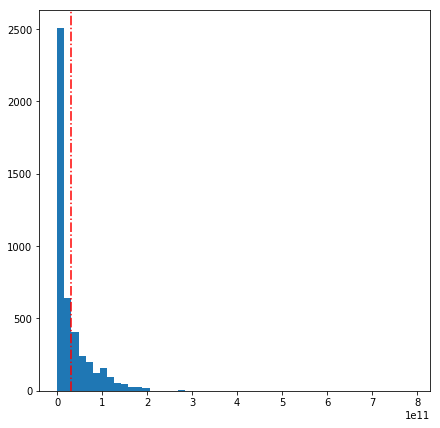

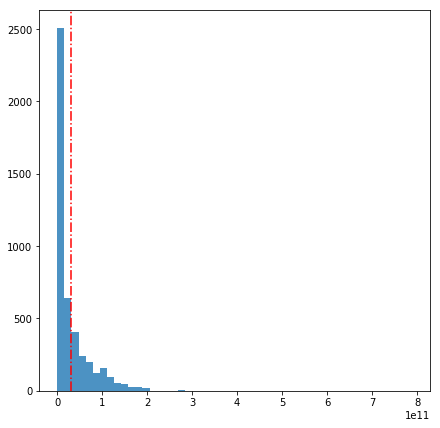

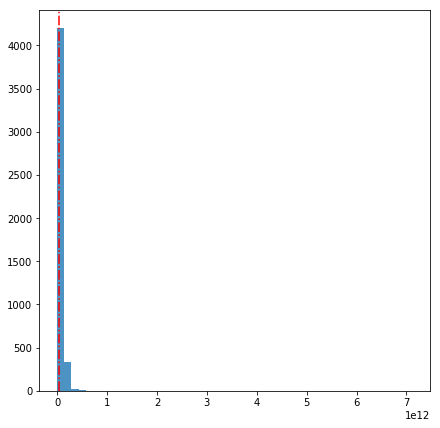

In [80]:
manga_mass = basic_manga['PHOTOMETRIC_MASS']
manga_mass = manga_mass[tmp_num_ij[:,1]]    # 匹配数组维度

plt.figure(figsize=(7,7))
#hist, xbins, cax = plt.hist(manga_mass,bins=50)
plt.hist(manga_mass,bins=50);
plt.axvline(np.mean(manga_mass),color='r',linestyle='-.');

nsa_mass1 = copy.copy(basic_nsa['ELPETRO_MASS'])    #Stellar mass from K-correction fit (use with caution) for elliptical Petrosian fluxes
nsa_mass2 = copy.copy(basic_nsa['SERSIC_MASS'])    #Stellar mass from K-correction fit (use with caution) for Sersic fluxes
nsa_mass1 = nsa_mass1[tmp_num_ij[:,0]]
nsa_mass2 = nsa_mass2[tmp_num_ij[:,0]]  

plt.figure(figsize=(7,7))
plt.hist(nsa_mass1,bins=50,alpha=0.8);
plt.axvline(np.mean(nsa_mass1),color='r',linestyle='-.');
# plt.hist(nair_ba,bins=delta_bins);
# plt.hist(old_ba,bins=delta_bins,alpha=0.8);

plt.figure(figsize=(7,7))
plt.hist(nsa_mass2,bins=50,alpha=0.8);
plt.axvline(np.mean(nsa_mass2),color='r',linestyle='-.');

print(np.mean(manga_mass))
print(np.shape(manga_mass))

print("\n",np.mean(nsa_mass1))
print(np.shape(nsa_mass1))

(0, 200000000000.0)

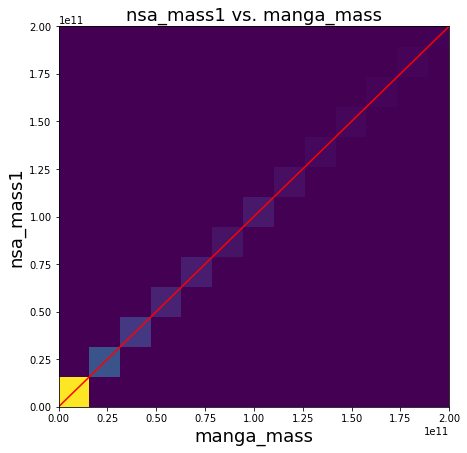

In [82]:
plt.figure(figsize=(7,7))
xx=np.linspace(0,2e11,10)
plt.plot(xx,xx,color = 'r')
plt.hist2d(manga_mass,nsa_mass1,bins=(50,50));
plt.xlabel("manga_mass",fontsize = 18)
plt.ylabel("nsa_mass1",fontsize = 18)
plt.title("nsa_mass1 vs. manga_mass",fontsize = 18)
plt.xlim(0, 2e11)
plt.ylim(0, 2e11)

In [15]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.io import fits
import copy
from os.path import join
import math
import numpy as np
from matplotlib.colors import ListedColormap
from marvin.tools import Maps
import marvin.utils.plot.map as mapplot

new_ra_dec = np.loadtxt('/root/cosmos/data/nair_ra_dec_ba.txt')

# 读取nsa与manga的匹配数组
nsa_vs_manga = np.loadtxt("/root/.jupyter/cosmos/code_git/Metallicity-deviation/tmp_storage/nsa101_vs_manga.dat")

#read in the vac file
vac0 = fits.open('/root/cosmos/galaxies-mzr/data/manga_firefly-v2_4_3-STELLARPOP.fits') 
basic_manga = copy.copy(vac0[1].data)

# load the data of NASA-Sloan catalog v1 0 1
nsa101 = fits.open('/root/cosmos/data/nsa_v1_0_1.fits') 
basic_nsa = nsa101[1].data
nsa_ba = copy.copy(basic_nsa['PETRO_BA90'])
nsa_mass1 = copy.copy(basic_nsa['ELPETRO_MASS'])    #Stellar mass from K-correction fit (use with caution) for elliptical Petrosian fluxes
nsa_mass2 = copy.copy(basic_nsa['SERSIC_MASS'])    #Stellar mass from K-correction fit (use with caution) for Sersic fluxes

# http://skyserver.sdss.org/dr15/en/tools/search/IQS.aspx
# 衡量星系的年龄大小的量 fracDeV<0.7
fracDeV = np.loadtxt('lalala_manga_fradeV.txt')

# https://www.sdss.org/dr12/algorithms/classify/#photo_adaptive
# http://skyserver.sdss.org/dr15/en/help/docs/QS_UserGuide.aspx#SAS
# 筛选倾斜程度，椭圆的长轴短轴为a b
# 计算出每个星系的a b
# b/a>=0.3
#q_u = np.loadtxt('manga_Q_U_4675.txt')
#b_over_a = 2/((q_u[:,0]**2+q_u[:,1]**2)**0.5+1)-1


#########################################
# 去重
tmp_num_ij = nsa_vs_manga    # 临时存储一下，防止改动
#tmp_num_ij = tmp_num_ij[np.where((old_same_gal[:,0]==1) & (~np.isnan(nsa_ba)) & (tmp_num_ij[:,0]!=-999))]    # 筛选出未重复的星系编号 & 剔除无效数据nan
tmp_num_ij = tmp_num_ij[np.where(~np.isnan(nsa_ba))]    # 剔除nsa_b/a无效数据nan
tmp_num_ij = tmp_num_ij[np.where(tmp_num_ij[:,0]!=-999)]    # 将匹配到的有效位置提出，-999为初始值
a,last_num = np.unique(tmp_num_ij[:,0],return_index=True)    # 第一列nsa数据去重
tmp_num_ij = tmp_num_ij[last_num]
#tmp_num_ij = tmp_num_ij[np.where(~np.isnan(nsa_ba))]    # 
#a,num_last_same_gal = np.unique(last_same_gal[np.where(old_same_gal[:,0]==1),0],return_index=True)    # 第一列sdss数据去重
a,last_num = np.unique(tmp_num_ij[:,1],return_index=True)    # 第二列manga数据去重
tmp_num_ij = tmp_num_ij[last_num]
tmp_num_ij = tmp_num_ij.astype(np.int64)    #最后得到了最终版的nsa_vs_manga数组位置
######################################
nsa_vs_manga = tmp_num_ij



manga_vs_nair = np.loadtxt("/root/.jupyter/cosmos/code_git/Metallicity-deviation/tmp_storage/manga_vs_nair.dat")
manga_vs_nair = manga_vs_nair.astype(np.int64) 


# 去重
manga_vs_nair = manga_vs_nair[np.where(manga_vs_nair[:,0]!=-999)]
a,last_num = np.unique(manga_vs_nair[:,1],return_index=True)    # 第二列nair数据去重
manga_vs_nair = manga_vs_nair[last_num]
nair_ra_dec_ba = np.loadtxt('/root/cosmos/data/nair_ra_dec_ba.txt')

plt_nsa_nair = np.zeros([nsa_vs_manga[:,0].size,2])-999
for i in range(0,nsa_vs_manga[:,0].size):    
    for j in range(0,manga_vs_nair[:,0].size):    
        if (nsa_vs_manga[i,1]==manga_vs_nair[j,0])and(nair_ra_dec_ba[manga_vs_nair[j,1],2]<=1):
            plt_nsa_nair[i,0] = nsa_vs_manga[i,0]
            plt_nsa_nair[i,1] = manga_vs_nair[j,1]

/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: ResourceWarning: unclosed file <_io.FileIO name='/root/cosmos/galaxies-mzr/data/manga_firefly-v2_4_3-STELLARPOP.fits' mode='rb' closefd=True>
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: ResourceWarning: unclosed file <_io.FileIO name='/root/cosmos/data/nsa_v1_0_1.fits' mode='rb' closefd=True>


manga和nair匹配到  1096  个星系


(0, 1)

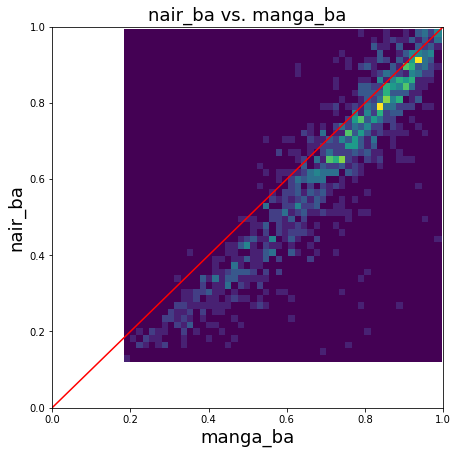

In [16]:
plt_nsa_nair = plt_nsa_nair[np.where(plt_nsa_nair[:,0]!=-999)]    # 去除无效数据
plt_nsa_nair = plt_nsa_nair.astype(np.int64)  






manga_ba = nsa_ba[plt_nsa_nair[:,0]]
nair_ba = nair_ra_dec_ba[plt_nsa_nair[:,1],2]
print("manga和nair匹配到 ",manga_ba.size," 个星系")

plt.figure(figsize=(7,7))
xx=np.linspace(0,1,10)
plt.plot(xx,xx,color = 'r')
plt.hist2d(manga_ba,nair_ba,bins=(50,50));
plt.xlabel("manga_ba",fontsize = 18)
plt.ylabel("nair_ba",fontsize = 18)
plt.title("nair_ba vs. manga_ba",fontsize = 18)
plt.xlim(0, 1)
plt.ylim(0, 1)

In [20]:
print(np.mean(manga_ba))
print(np.mean(nair_ba))

0.7196693
0.650131386861314


In [5]:
manga_vs_nair = np.loadtxt("/root/.jupyter/cosmos/code_git/Metallicity-deviation/tmp_storage/manga_vs_nair.dat")
np.min(manga_vs_nair)

-999.0

In [40]:
# 开始筛选，在第三列进行判断计数
fra_b_over_a[np.where(fra_b_over_a[:,0]<0.7),2] += 1    # fracDeV筛选
fra_b_over_a[np.where(fra_b_over_a[:,1]>=0.3),2] += 1    # b/a筛选
fra_b_over_a[np.where(glo_mass_id),2] += 1    # 星系总质量筛选
fra_b_over_a[sfr_id,2] += 1    # 星系形成区域筛选

sel_galaxy = np.where(fra_b_over_a[:,2]==4)    # 四次筛选结果

print("不考虑nair catalog时：","\n已从 manga 4675 个星系中找出 ",np.shape(sel_galaxy)[1]," 个星系","\n距论文中的 1222 个星系还差  ",np.shape(sel_galaxy)[1]-1222,"个")
print("\n替换nair_ba之前，b/a平均值 = ",np.mean(fra_b_over_a[:,1]))


#########################################################
# 第五次筛选：manga与nair匹配的星系中，nair_b/a < manga_b/a

# 读取manga vs nair 匹配数组
last_same_gal = np.loadtxt("/root/.jupyter/cosmos/code_git/Metallicity-deviation/tmp_storage/manga_vs_nair.dat")
# 去重
tmp_num_ij = last_same_gal    # 临时存储一下，防止改动
tmp_num_ij = tmp_num_ij[np.where(tmp_num_ij[:,0]!=-999)]    # 筛选出未重复的星系编号
#tmp_num_ij = tmp_num_ij[np.where(old_same_gal[:,0]==1)]    # 筛选出未重复的星系编号
#a,num_last_same_gal = np.unique(last_same_gal[np.where(old_same_gal[:,0]==1),0],return_index=True)    # 第一列sdss数据去重
a,last_num = np.unique(tmp_num_ij[:,1],return_index=True)    # 第二列nair数据去重，last_num为最后编号
tmp_num_ij = tmp_num_ij[last_num]
tmp_num_ij = tmp_num_ij.astype(np.int64)
# manga数组编号为tmp_num_ij[:,0]
# nair catalog 的b/a为nair_ba
nair_ba = new_ra_dec[tmp_num_ij[:,1],2]    #nair catalog 中的b/a
# 剔除999999坏数据
tmp_num_ij = tmp_num_ij[np.where(nair_ba!=999999)]
nair_manga_id = tmp_num_ij    # 最终版的manga_vs_nair
nair_ba = nair_ba[np.where(nair_ba!=999999)]    # nair catalog 的 b/a

# nair_b/a中较小的值
nair_manga_id = nair_manga_id[np.where(nair_ba<=1)]    # 数组位置进行同步筛选
nair_ba = nair_ba[np.where(nair_ba<=1)]


manga_ba = fra_b_over_a[:,1]    # 原始b/a，数据来源于nsa_v101
#manga_id前面已赋值4561个星系，即所在的数组位置信息

# for 循环将manga_ba的值替换成nair中b/a较小的值
for i in range(0,manga_ba.size):    # 循环nsa
    for j in range(0,nair_ba.size):    # 循环nair
        if (manga_id[i]==nair_manga_id[j,1])and(manga_ba[i] > nair_ba[j]):
            #manga_ba[i] = 0
            manga_ba[i] = nair_ba[j]
        #if manga_id[i]==nair_manga_id[j,1]:
            #fra_b_over_a[i,2]+=1

fra_b_over_a[:,1] = manga_ba    # 替换完成
fra_b_over_a[np.where(fra_b_over_a[:,1]>=0.3),2] += 1    # 加入nair的b/a之后的筛选
sel_galaxy = np.where(fra_b_over_a[:,2]==5)    # 五次筛选结果

# ###################################################################
# # 第六次筛选：nair_ba>=0.3，匹配星系在nair中小于某一值
# # 先尝试0.3，论文中的条件为：中位数0.3，平均数0.31【对于整体14000样本而言】
# # 通过循环，逐渐尝试nair_ba<x, 一直到某个x满足上述条件
# # 之后再与manga进行匹配，从manga中剔除匹配到的倾斜较大的星系


# # 读取manga vs nair 匹配数组
# last_same_gal = np.loadtxt("/root/.jupyter/cosmos/code_git/Metallicity-deviation/tmp_storage/manga_vs_nair.dat")
# # 去重
# tmp_num_ij = last_same_gal    # 临时存储一下，防止改动
# tmp_num_ij = tmp_num_ij[np.where(old_same_gal[:,0]==1)]    # 筛选出未重复的星系编号
# #a,num_last_same_gal = np.unique(last_same_gal[np.where(old_same_gal[:,0]==1),0],return_index=True)    # 第一列sdss数据去重
# a,last_num = np.unique(tmp_num_ij[:,1],return_index=True)    # 第二列nair数据去重，last_num为最后编号
# tmp_num_ij = tmp_num_ij[last_num]
# tmp_num_ij = tmp_num_ij.astype(np.int64)
# # manga数组编号为tmp_num_ij[:,0]
# # nair catalog 的b/a为nair_ba
# nair_ba = new_ra_dec[tmp_num_ij[:,1],2]    #nair catalog 中的b/a
# # 剔除999999坏数据
# tmp_num_ij = tmp_num_ij[np.where(nair_ba!=999999)]
# nair_manga_id = tmp_num_ij    # 最终版的manga_vs_nair
# nair_ba = nair_ba[np.where(nair_ba!=999999)]    # nair catalog 的 b/a

# # nair_b/a中较小的值
# nair_ba = nair_ba[np.where(nair_ba<1)]
# nair_manga_id = nair_manga_id[np.where(nair_ba<1)]    # 数组位置进行同步筛选

# manga_ba = fra_b_over_a[:,1]    # 原始b/a，数据来源于nsa_v101
# #manga_id前面已赋值4561个星系，即所在的数组位置信息

# # for 循环将manga_ba的值替换成nair中b/a较小的值
# for i in range(0,manga_ba.size):    # 循环nsa
#     for j in range(0,nair_ba.size):    # 循环nair
#         if (manga_id[i]==nair_manga_id[j,1])&(manga_ba[i] > nair_ba[j]):
#             manga_ba[i] = nair_ba[j]
#             #fra_b_over_a[i,2]+=1
            

            
# fra_b_over_a[:,1] = manga_ba    # 替换完成
# fra_b_over_a[np.where(fra_b_over_a[:,1]>=0.3),2] += 1    # 加入nair的b/a之后的筛选
# sel_galaxy = np.where(fra_b_over_a[:,2]==6)    # 六次筛选结果



# # 第七次筛选：通过限定匹配星系在nair中大于某一值
# # nair catalog 的b/a为nair_ba
# nair_ba = new_ra_dec[tmp_num_ij[:,1],2]    #nair catalog 中的b/a
# # 剔除999999坏数据
# tmp_num_ij = tmp_num_ij[np.where(nair_ba!=999999)]
# nair_manga_id = tmp_num_ij    # 最终版的manga_vs_nair
# nair_ba = nair_ba[np.where(nair_ba!=999999)]    # nair catalog 的 b/a

# # nair_b/a中较大的值
# nair_ba = nair_ba[np.where(nair_ba>0.8)]
# nair_manga_id = nair_manga_id[np.where(nair_ba>0.8)]    # 数组位置进行同步筛选

# manga_ba = fra_b_over_a[:,1]    # 原始b/a，数据来源于nsa_v101
# #manga_id前面已赋值4561个星系，即所在的数组位置信息

# # for 循环将manga_ba的值替换成nair中b/a较小的值
# for i in range(0,manga_ba.size):    # 循环nsa
#     for j in range(0,nair_ba.size):    # 循环nair
#         if manga_id[i]==nair_manga_id[j,1]:
#             manga_ba[i] = nair_ba[j]
#             #fra_b_over_a[i,2]+=1
            

            
# fra_b_over_a[:,1] = manga_ba    # 替换完成
# fra_b_over_a[np.where(fra_b_over_a[:,1]>=0.3),2] += 1    # 加入nair的b/a之后的筛选
# sel_galaxy = np.where(fra_b_over_a[:,2]==6)    # 七次次筛选结果

print("替换nair_ba之后，b/a平均值 = ",np.mean(fra_b_over_a[:,1]))
print("\n考虑nair catalog时：","\n已从 manga 4675 个星系中找出 ",np.shape(sel_galaxy)[1]," 个星系","\n距论文中的 1222 个星系还差  ",np.shape(sel_galaxy)[1]-1222,"个")

不考虑nair catalog时： 
已从 manga 4675 个星系中找出  1612  个星系 
距论文中的 1222 个星系还差   390 个

替换nair_ba之前，b/a平均值 =  0.6989220308384543
替换nair_ba之后，b/a平均值 =  0.6912061108969408

考虑nair catalog时： 
已从 manga 4675 个星系中找出  1601  个星系 
距论文中的 1222 个星系还差   379 个


In [21]:
last_same_gal = np.loadtxt("/root/.jupyter/cosmos/code_git/Metallicity-deviation/tmp_storage/manga_vs_nair.dat")

last_same_gal = plfu_sfr[:,2]
print(last_same_gal.shape)
print(np.min(last_same_gal))
print(np.max(last_same_gal[:,0]))
print(np.max(last_same_gal[:,1]))
print(np.shape(np.where(last_same_gal[:,0]==-999)))
print(np.shape(np.where(last_same_gal[:,1]==-999)))

(4561,)
0.0


IndexError: too many indices for array

In [28]:
plfu_sfr = np.loadtxt("/root/.jupyter/cosmos/code_git/Metallicity-deviation/plfu_sfr_spaxel.dat")
plfu_sfr[55:60]

array([[ 8486.,  9101.,   182.],
       [ 8601.,  3702.,     0.],
       [ 8319., 12701.,     0.],
       [ 8933.,  6104.,     0.],
       [ 8154., 12705.,  1308.]])